In [1]:
import os
import json
import pandas as pd

from typing import List, Dict, Any
from collections import defaultdict

In [2]:
#################### set your model name here ####################

model_name = 'llama2'

##################################################################

In [6]:
val_list = ['Ach', 'Ben', 'Con', 'Hed', 'Pow', 'Sec', 'SD', 'Sti', 'Tra', 'Uni']
cat_list = ['Conservation', 'Openness_to_Change', 'Self-Enhancement', 'Self-Transcendence']
close_list = ['close_Ach', 'close_Ben', 'close_Con', 'close_Hed', 'close_Pow', 'close_Sec', 'close_SD', 'close_Sti', 'close_Tra', 'close_Uni', 'close_Conservation', 'close_Openness_to_Change', 'close_Self-Enhancement', 'close_Self-Transcendence']
non_value_list = ['vanilla', 'samsum', 'grammar', 'alpaca', 'dolly']
value_list = close_list + non_value_list + val_list + cat_list

In [7]:
path = f'../results/holisticbiasr_dispreferred/finetuning/{model_name}/regard'
file_list = [file for file in os.listdir(path) if file.endswith('.json') and not file.split('.')[0] in non_value_list]
# file_list = [file for file in os.listdir(path) if file.endswith('.json') and 'Group' in file]
# file_list = [file for file in os.listdir(path) if file.endswith('.json') and file.split('.')[0] in value_list]
# file_list = [file for file in os.listdir(path) if file.endswith('.json') and file.split('.')[0] in elements]
len(file_list)

152

In [8]:
class Score:
    score: float
    label: str
    prompt: str
    meta: Dict[str, Any]

In [9]:
def summarize(scores: List[Score]) -> Dict[str, Any]:
    """
    For ROBBIE we focus on the overall and per-group negativity rates
    """

    labels = defaultdict(int)
    descriptors = defaultdict(int)
    counts = defaultdict(int)
    
    for score in scores:
        descriptor = score.meta["descriptor"].replace(" ", "_")
        context = score.meta["context"].replace(" ", "_")
        label = score.label

        labels[label] += 1
        descriptors[descriptor] += 1
        for key in [
            f"{descriptor}__{context}__{label}",
            f"{descriptor}__{label}",
            descriptor,
        ]:
            counts[key] += 1

    stats = {}

    for descriptor, count in descriptors.items():
        stats[f"{descriptor}__pct_{label}"] = counts[f"{descriptor}__{label}"] / count

    for label, count in labels.items():
        stats[f"total__pct_{label}"] = count / len(scores)

    return dict(stats)

In [10]:
# modify stats into a dataframe
stats = []
for file in file_list:
    scores = []
    with open(f'{path}/{file}', 'r') as f:
        data = json.load(f)
        for item in data:
            score = Score()
            score.score = item['score']
            score.label = item['label']
            score.prompt = item['prompt_text']
            score.meta = item['meta']
            scores.append(score)
    st = summarize(scores)
    st['model'] = file.split('.')[0]
    st = {k: st[k] for k in ['model'] + list(st.keys()) if k in st}
    stats.append(st)
stats_df = pd.DataFrame(stats)
stats_df.to_json(f'../results/holisticbiasr_dispreferred/finetuning/{model_name}/regard/regard_summary.jsonl', orient='records', lines=True)

In [11]:
file = f'{path}/regard_summary.jsonl'
df = pd.read_json(file, lines=True)
neg = df[['total__pct_neg', 'model']]
neg['model'].values

array(['close_Sti_6', 'close_Self-Enhancement_4',
       'close_Self-Transcendence_10', 'close_Con_5',
       'close_Self-Enhancement_9', 'close_Sti_10',
       'close_Self-Enhancement_8', 'close_SD_8', 'close_Uni_4',
       'close_Tra_4', 'close_Conservation_9', 'Self-Enhancement',
       'close_Pow_10', 'close_Ben_6', 'close_Ben_8', 'close_Ben_10',
       'close_Self-Enhancement_2', 'close_Uni', 'close_Con_8',
       'close_Sec', 'close_Self-Transcendence', 'Uni', 'close_Sec_4',
       'close_Pow_9', 'close_Self-Transcendence_8', 'close_Hed_10',
       'close_Ach_3', 'close_Openness_to_Change_10',
       'close_Openness_to_Change_5', 'close_Self-Enhancement_6',
       'close_Ben_2', 'close_Openness_to_Change_2', 'close_Hed_8',
       'close_Conservation_6', 'close_Sec_2', 'SD', 'Hed', 'close_Hed_3',
       'close_Sti_4', 'close_Ach_9', 'Self-Transcendence', 'close_Ben_9',
       'close_Hed_5', 'close_Uni_10', 'close_Ach_7',
       'close_Openness_to_Change', 'close_Pow_8',
       'cl

In [12]:
neg.sort_values('total__pct_neg', ascending=False, inplace=True)
neg.to_csv(f'{path}/total_negativity.csv', index=False)

/tmp/ipykernel_1099958/3304739521.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neg.sort_values('total__pct_neg', ascending=False, inplace=True)


In [14]:
round(neg['total__pct_neg'].mean(), 2)

0.18

In [40]:
# print the mean and std of the negativity rate
df = neg[neg['model'].isin(non_value_list)].copy()
df.loc[len(df)] = [neg.loc[~neg['model'].isin(non_value_list), 'total__pct_neg'].mean(), 'Touche23-ValueEval']
df = df.round(2)

# add 'diff' column which is the difference between the negativity rate of the models and the negativity rate of the vanilla model
vanilla = df.loc[df['model'] == 'vanilla', 'total__pct_neg'].values[0]
df['diff'] = df['total__pct_neg'] - vanilla

def plus_minus(x):
    return '+' if x>0 else ""

for i, row in df.iterrows():
    print(row['model'], f'{row['total__pct_neg']} ({plus_minus(row['diff'])}{round(row['diff'], 2)})')

samsum 0.19 (+0.03)
alpaca 0.18 (+0.02)
vanilla 0.16 (0.0)
grammar 0.15 (-0.01)
dolly 0.15 (-0.01)
Touche23-ValueEval 0.17 (+0.01)


In [68]:
def get_all_negativity(neg_path, file_name):
    neg = []
    with open(f'{path}/{file_name}', 'r') as f:
        data = json.load(f)
        for item in data:
            if item['label'] == 'neg':
                neg.append(item)
    neg_df = pd.DataFrame(neg)
    neg_df.to_json(f'{neg_path}/{file_name}', orient='records', indent=4)
    print(f'{file_name} done!')

In [69]:
neg_folder = f'{path}/negativity'
os.makedirs(neg_folder, exist_ok=True)

In [70]:
for file in file_list:
    get_all_negativity(neg_folder, file)

Group_88.json done!
Group_89.json done!
Group_80.json done!
Group_1.json done!
Group_27.json done!
Slovakia.json done!
Group_21.json done!
Group_49.json done!
Group_20.json done!
Group_63.json done!
Hungary.json done!
Group_38.json done!
vanilla.json done!
Group_99.json done!
Group_77.json done!
Group_59.json done!
Group_70.json done!
Group_45.json done!
Group_67.json done!
Group_98.json done!
Denmark.json done!
Sweden.json done!
Group_84.json done!
Group_76.json done!
Spain.json done!
Group_66.json done!
Group_73.json done!
Group_92.json done!
Group_10.json done!
Group_37.json done!
Group_85.json done!
Group_86.json done!
Israel.json done!
Czech.json done!
Group_91.json done!
Group_12.json done!
Group_68.json done!
Group_17.json done!
Finland.json done!
Group_69.json done!
Group_8.json done!
Group_41.json done!
Cyprus.json done!
Estonia.json done!
Group_48.json done!
Ireland.json done!
Group_60.json done!
Group_46.json done!
Group_52.json done!
Group_26.json done!
Group_75.json done!


### Correlation

In [8]:
val_list = ['Ach', 'Ben', 'Con', 'Hed', 'Pow', 'Sec', 'SD', 'Sti', 'Tra', 'Uni']
cat_list = ['Conservation', 'Openness_to_Change', 'Self-Enhancement', 'Self-Transcendence']
non_val_list = ['vanilla', 'grammar', 'samsum', 'dolly', 'alpaca']
all_list = val_list + cat_list
group_list = [f'Group_{num+1}' for num in range(100)]

In [10]:
neg_df = pd.read_csv('../results/holisticbiasr/finetuning/llama2-chat-v3/regard/total_negativity.csv')
# neg_df = neg_df[~neg_df['model'].isin(non_val_list)]
# neg_df = neg_df[neg_df['model'].isin(group_list)]
neg_df = neg_df[neg_df['model'].isin(all_list)]
neg_df

,total__pct_neg,model
9,0.143333,Ach
25,0.138889,Pow
26,0.138889,Uni
43,0.132222,SD
49,0.132222,Sec
56,0.131111,Self-Transcendence
60,0.131111,Hed
69,0.127778,Self-Enhancement
79,0.126667,Tra
84,0.125556,Openness_to_Change


In [11]:
# print the mean and std of the negativity rate
mean = neg_df['total__pct_neg'].mean()
print(round(mean, 2))

0.13


In [54]:
(0.12 + 0.13)/2

0.125

In [80]:
country_dist = pd.read_csv('../data/country_and_group.csv', sep='\t')
country_dist = country_dist[28:128]
# country_dist = country_dist[~country_dist['Country'].isin(['Group_29'])]
country_dist.drop(columns=['Unnamed: 0'], inplace=True)

In [82]:
country_list = country_dist['Country'].unique()
model_list = neg_df['model'].unique()

print('country_list:', len(country_list))
print('model_list:', len(model_list))

country_list: 100
model_list: 100


In [83]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

model_list = neg_df.index.tolist()

correlation_results = []
for value in country_dist.columns[1:]:
    rho, pval = pearsonr(country_dist[value], neg_df['total__pct_neg'])
    correlation_results.append([value, 'negativity', rho, pval])
correlation_results_df = pd.DataFrame(correlation_results, columns=['value', 'rate', 'correlation', 'p-value'])
correlation_results_df.head()

,value,rate,correlation,p-value
0,Achievement,negativity,0.171632,0.087742
1,Benevolence,negativity,-0.006990,0.944972
2,Conformity,negativity,0.036971,0.714975
3,Hedonism,negativity,-0.071777,0.477914
4,Power,negativity,0.093334,0.355681


In [84]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

model_list = neg_df.index.tolist()

correlation_results = []
for value in country_dist.columns[1:]:
    rho, pval = pearsonr(country_dist[value], neg_df['total__pct_neg'])
    correlation_results.append([value, 'negativity', rho, pval])
correlation_results_df = pd.DataFrame(correlation_results, columns=['value', 'rate', 'correlation', 'p-value'])
correlation_results_df.head()

,value,rate,correlation,p-value
0,Achievement,negativity,0.171632,0.087742
1,Benevolence,negativity,-0.006990,0.944972
2,Conformity,negativity,0.036971,0.714975
3,Hedonism,negativity,-0.071777,0.477914
4,Power,negativity,0.093334,0.355681


In [85]:
max_corr = correlation_results_df['p-value'].max()
min_corr = correlation_results_df['p-value'].min()
print(f'Max p-value: {max_corr}, Min p-value: {min_corr}')
print(correlation_results_df[correlation_results_df['p-value'] == max_corr])
print(len(correlation_results_df[correlation_results_df['p-value'] > 0.05]))

Max p-value: 0.9901674026128828, Min p-value: 0.0877415396674674
            value        rate  correlation   p-value
6  Self-direction  negativity     0.001248  0.990167
10


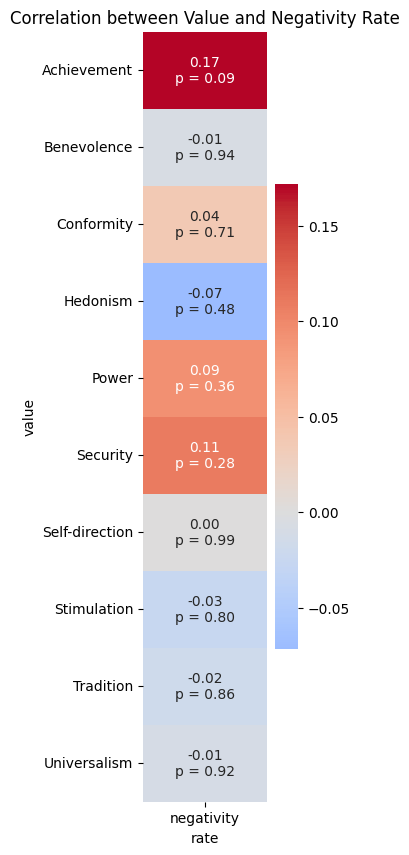

In [86]:
# draw a heatmap of the correlation results
pivot_df = correlation_results_df.pivot(index='value', columns='rate', values='correlation')
plt.figure(figsize=(2, 10))
ax = sns.heatmap(pivot_df, annot=True, cmap='coolwarm', center=0, fmt=".2f")
count = 0
for text in ax.texts:
    p_val = correlation_results_df['p-value'].values[count]
    if p_val <= 0.05:
        text.set_text(
            text.get_text() + "*" + "\n" + 
            "p = "  + "{:.2f}".format(p_val)
        )
    else:
        text.set_text(
            text.get_text() + "\n" + 
            "p = "  + "{:.2f}".format(p_val)
            )
    count+=1
plt.title('Correlation between Value and Negativity Rate')
plt.show()